https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [22]:
import pandas as pd 
import numpy as np 
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
import seaborn as sns 
import tensorflow as tf 
from sklearn.linear_model import LinearRegression

In [11]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Seasons'], axis=1)

In [15]:
df.columns = dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int)

In [18]:
df = df[df['hour'] == 12]
df = df.drop(['hour'], axis=1)

In [19]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


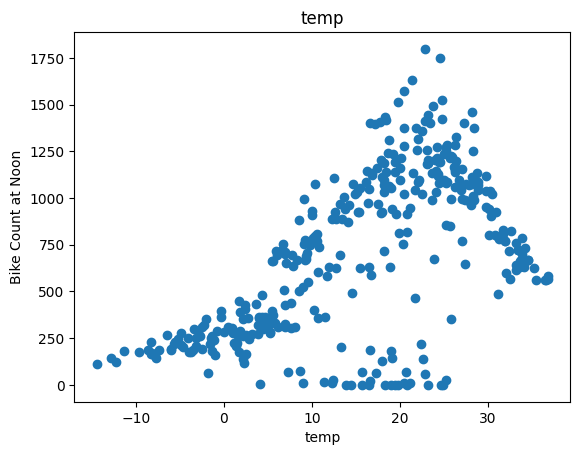

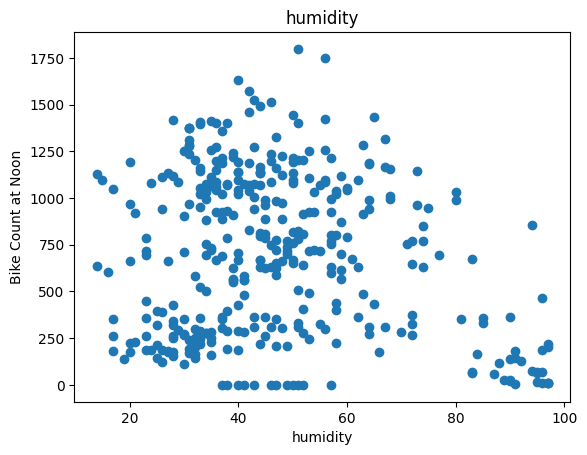

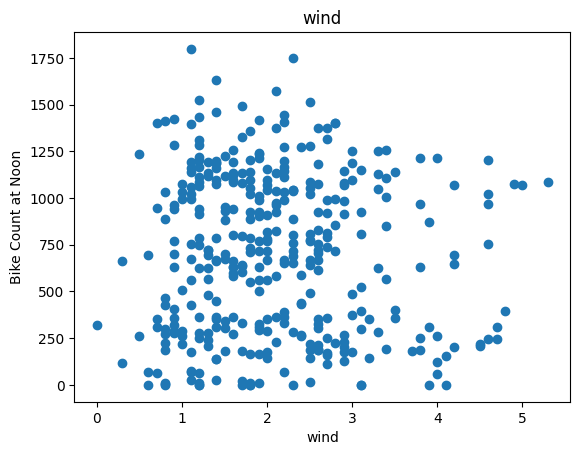

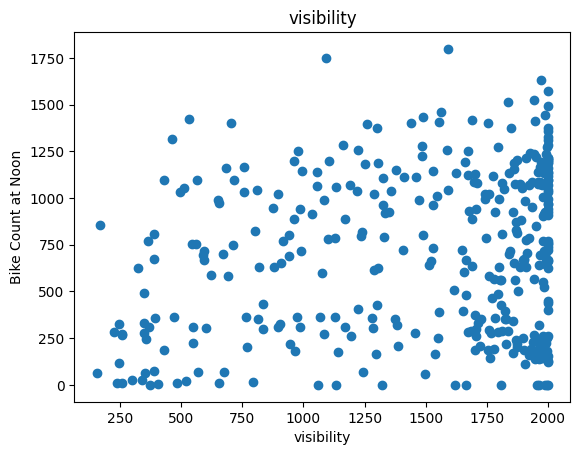

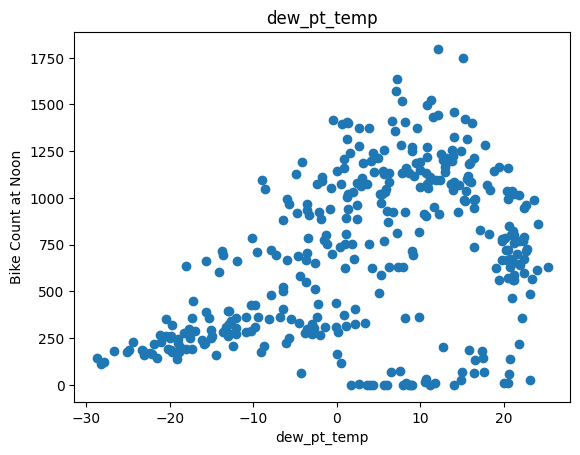

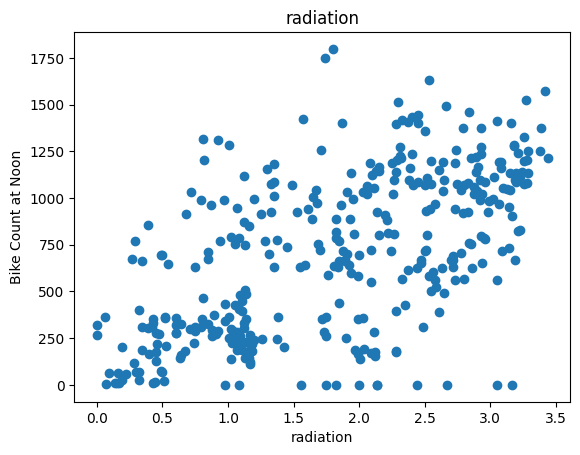

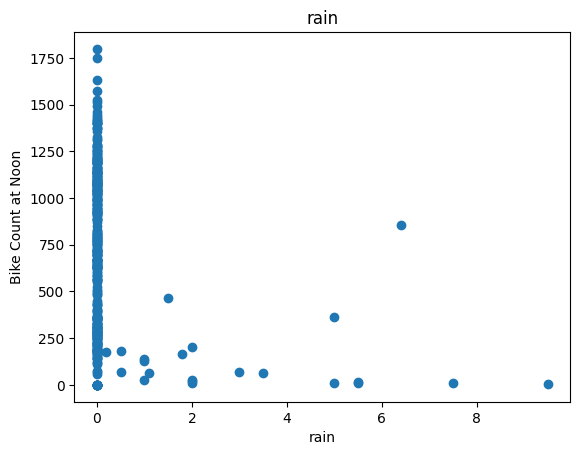

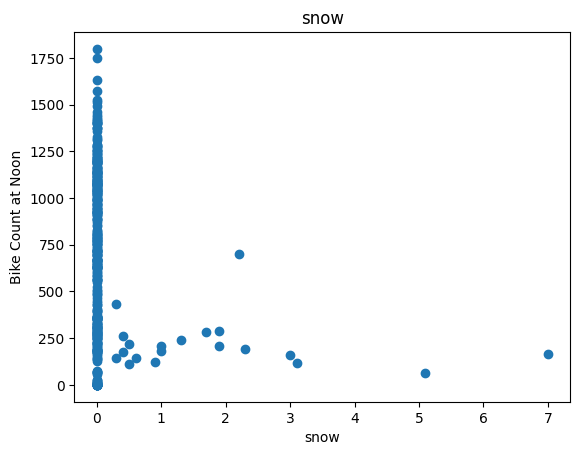

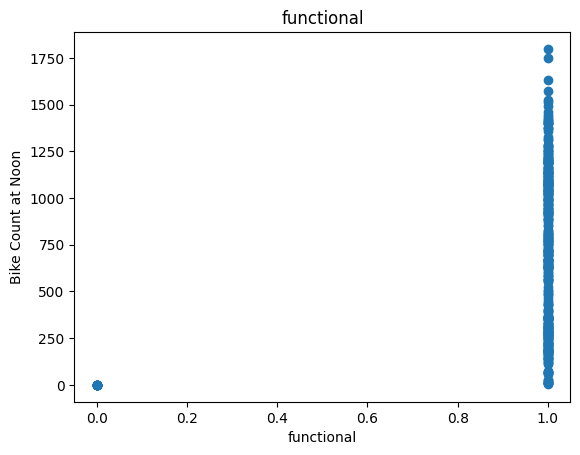

In [23]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at Noon')
    plt.xlabel(label)
    plt.show()

In [25]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)

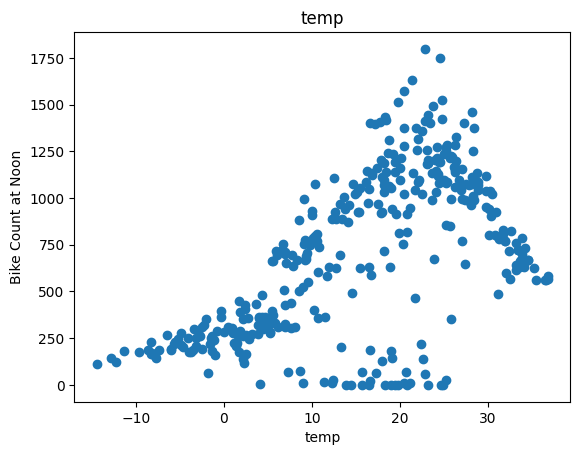

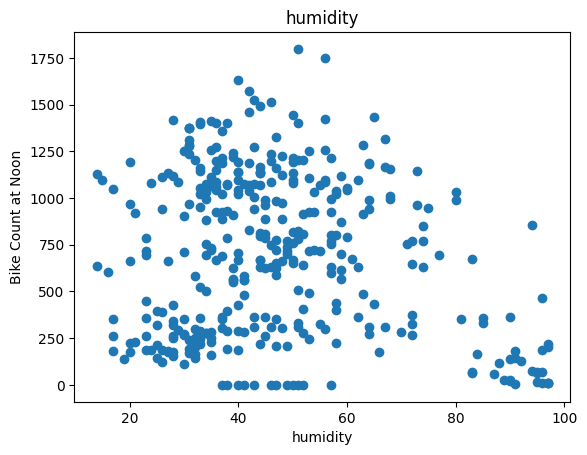

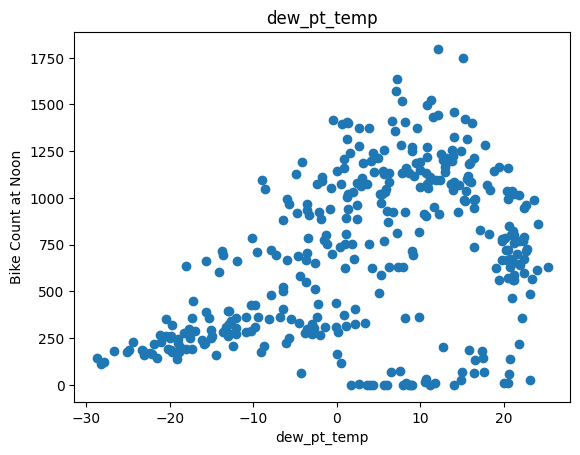

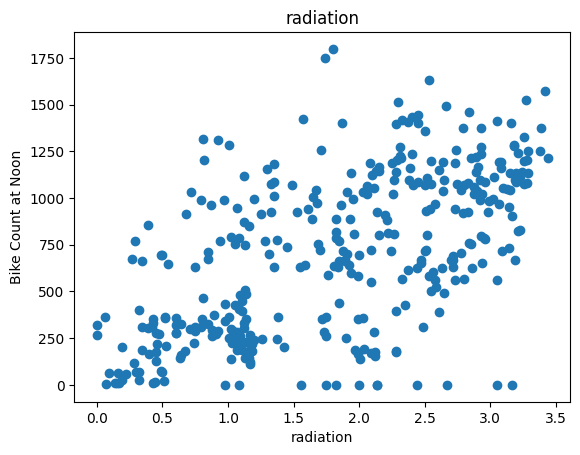

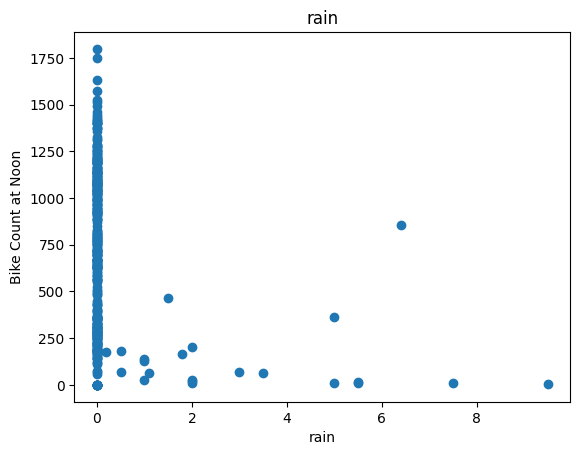

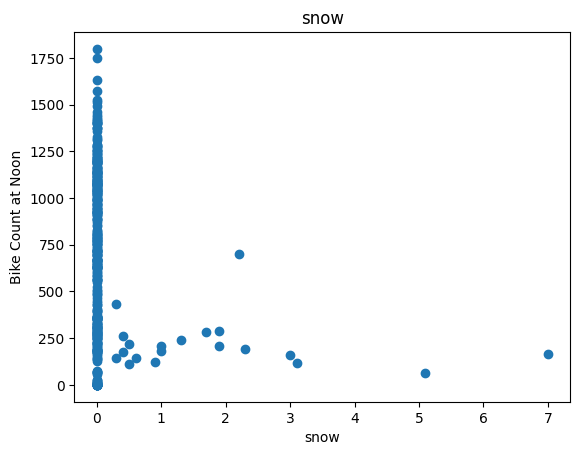

In [26]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at Noon')
    plt.xlabel(label)
    plt.show()

# Splitting dataset

In [54]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [55]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe([c for c in dataframe.columns if c != y.label]).values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [56]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', x_labels=['temp'])

In [57]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [58]:
print(temp_reg.coef_, temp_reg.intercept_)

[[21.25030523]] [363.07997648]


In [59]:
temp_reg.score(X_test_temp, y_test_temp)

0.3628727065373477

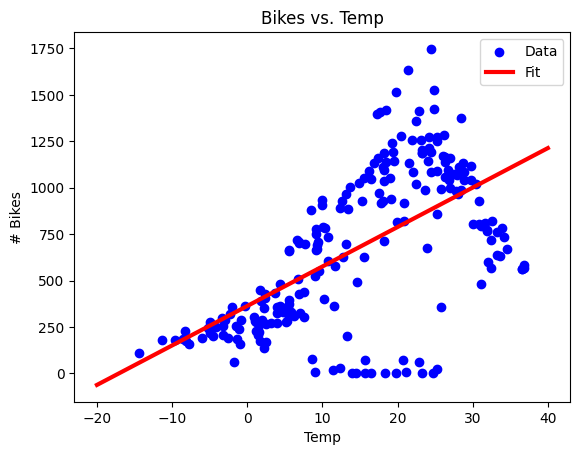

In [60]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs. Temp')
plt.ylabel('# Bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Linear Regression

In [91]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [92]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [135]:
all_reg.score(X_test_all, y_test_all)

0.583887569913726

In [137]:
y_pred_lr = all_reg.predict(X_test_all)

# Regression with NN

In [99]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [100]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [101]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [104]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [105]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 600239.8750 - val_loss: 734996.4375
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 600008.0000 - val_loss: 733461.8125
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 655301.1250 - val_loss: 731912.8750
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 611867.1250 - val_loss: 730400.2500
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 640769.6875 - val_loss: 728882.0000
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 565558.1875 - val_loss: 727390.0000
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 608214.4375 - val_loss: 725869.8125
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 608599.8125 - val_loss: 724362.3750
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 607479.8750 - val_loss: 722853.7500
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 626016.6250 - val_loss: 721351.4375
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

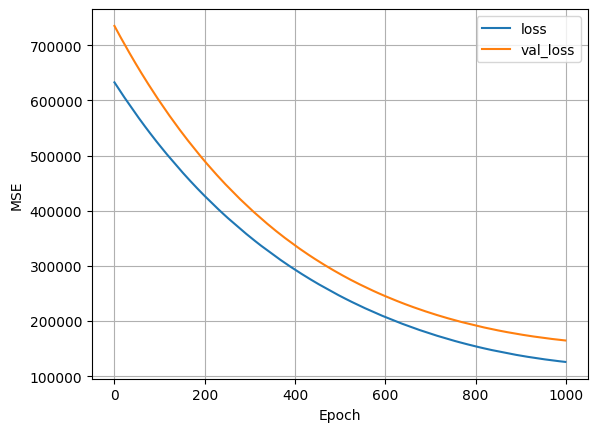

In [106]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


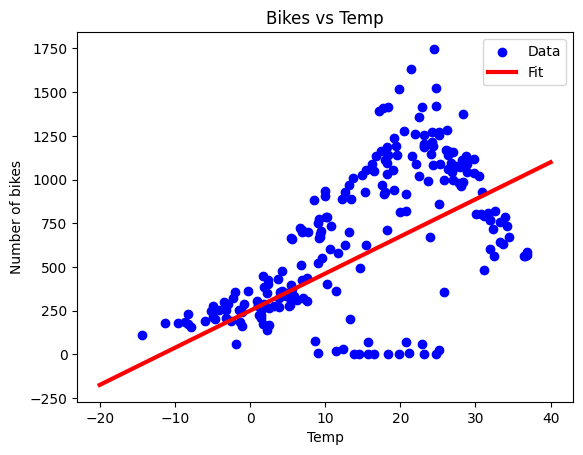

In [107]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# NN 

In [112]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [113]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_val_temp, y_val_temp),
    epochs=100
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 645873.0000 - val_loss: 737778.1250
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 631581.4375 - val_loss: 737658.1875
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 696560.8750 - val_loss: 737549.0625
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 658707.8750 - val_loss: 737430.6875
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 604804.1875 - val_loss: 737290.8125
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 590293.2500 - val_loss: 737111.7500
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 608007.3125 - val_loss: 736869.1250
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 601214.0000 - val_loss: 736533.8750
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 619907.1250 - val_loss: 736073.3750
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 632863.0000 - val_loss: 735456.8125
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 623522.1250

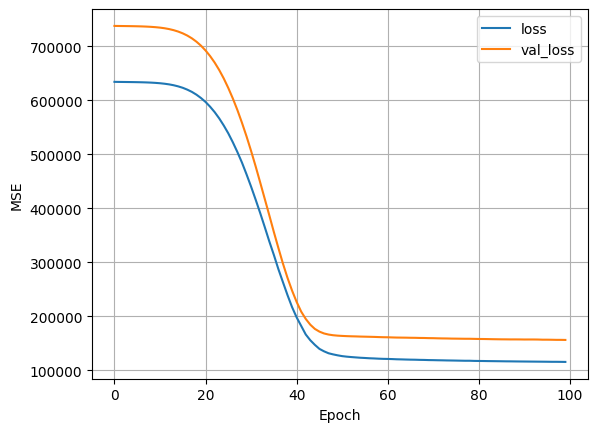

In [114]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


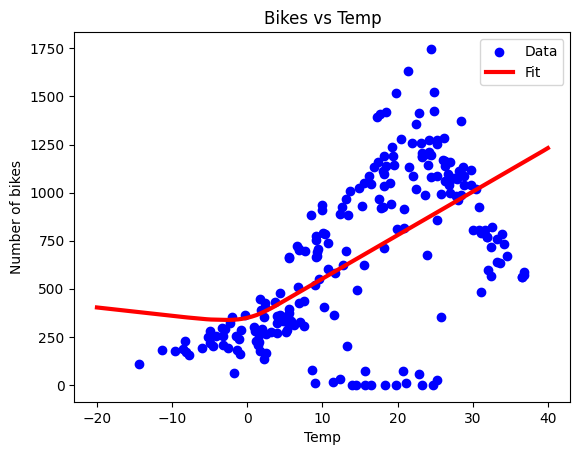

In [117]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [131]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [132]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [133]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_val_all, y_val_all),
    epochs=100
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 722345.7500 - val_loss: 587701.4375
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 655606.5625 - val_loss: 587393.4375
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 711299.9375 - val_loss: 587068.4375
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 734477.3750 - val_loss: 586718.1250
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 677616.8125 - val_loss: 586325.3125
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 693434.8125 - val_loss: 585876.7500
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 695258.3750 - val_loss: 585353.8750
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 675839.2500 - val_loss: 584747.0625
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 700621.5000 - val_loss: 584026.5625
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 708488.3125 - val_loss: 583179.6875
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 767067.5000

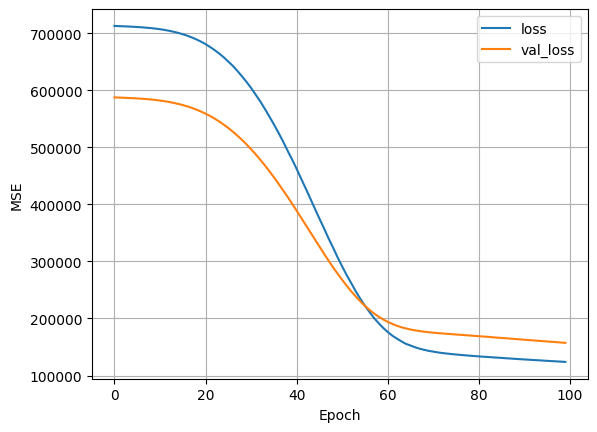

In [134]:
plot_loss(history)

In [138]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [139]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()


In [141]:
MSE(y_pred_lr, y_test_all)

63633.885067708216

In [142]:
MSE(y_pred_nn, y_test_all)

85246.2661550857

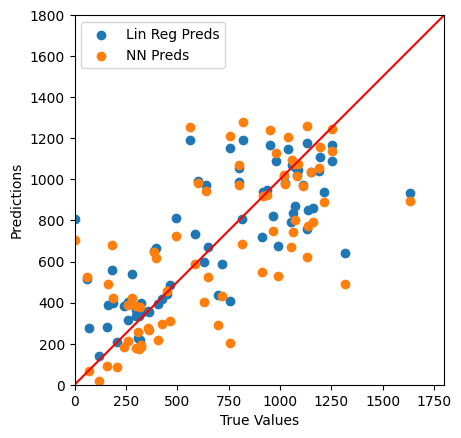

In [143]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")